# Synthetic inversion

## import packages

In [12]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


# Set region and parameters

In [13]:
# set grid parameters
registration = "g"

inversion_region = [0e3, 80e3, 0e3, 60e3]

buffer_region = utils.alter_region(
    inversion_region,
    buffer=20e3,
)[1]

print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-20000, 100000, -20000, 80000]


# Prep for the inversion

## load synthetic layers and full gravity grid

In [14]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1_simple.zarr").z

true_layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2_simple.zarr").z

layer3 = xr.open_zarr("../synthetic_data/synthetic_layer3_simple.zarr").z

synthetic_gravity = xr.open_zarr("../synthetic_data/synthetic_forward_grav_simple.zarr")

starting_layer2 = xr.open_zarr(
    "../synthetic_data/synthetic_starting_layer2_simple.zarr"
)["z"]

print(utils.get_grid_info(starting_layer2))
starting_layer2

(2000.0, [-20000.0, 100000.0, -20000.0, 80000.0], -827.3359375, -408.846160889, 'g')


<xarray.DataArray 'z' (y: 51, x: 61)>
dask.array<open_dataset-db6c752d116aefbd499accd1f04c1cc9z, shape=(51, 61), dtype=float32, chunksize=(51, 61), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2e+04 -1.8e+04 -1.6e+04 ... 9.6e+04 9.8e+04 1e+05
  * y        (y) float64 -2e+04 -1.8e+04 -1.6e+04 ... 7.6e+04 7.8e+04 8e+04
Attributes:
    actual_range:  [-827.3359375, -408.8461608886719]
    long_name:     z

## make a new layers dict
Note, this doesn't include Layer3 (the regional field) or the full-resolution bathymetry. This is so we can test whether the inversion is seperating the regional properly, and recovering the true bathymetry

In [4]:
active_layer = "layer2"

grav_spacing = 2e3  # true spacing was 2km

returned = inv_utils.import_layers(
    layers_list=[
        # "water",
        "layer2",
    ],
    spacing_list=[
        # 2e3, # true spacing was 1km
        2e3,
    ],
    rho_list=[
        # 0,#1030,
        2300
        - 1030,  # 2300,
    ],
    fname_list=[
        # "../synthetic_data/synthetic_layer1_simple.zarr",
        "../synthetic_data/synthetic_starting_layer2_simple.zarr",
    ],
    grav_file="../synthetic_data/synthetic_gravity_simple.csv.gz",
    constraint_points="../synthetic_data/synthetic_constraints_simple.csv.gz",
    grav_spacing=grav_spacing,
    active_layer=active_layer,
    buffer_region=buffer_region,
    inversion_region=inversion_region,
    registration=registration,
    # kwargs
    block_reduction="pygmt",
    input_grav_name="free_air_anomaly",
    input_obs_height_name="ellipsoidal_elevation",
    subset_constraints=False,
)
(
    inv_layers,
    grav,
    constraint_grid,
    constraint_points,
    constraint_points_subset,
) = returned

Block-reduced the gravity data at 2000m spacing
from 1271 points to 1271 points

********************Resampling layer2 layer ********************
returning original grid
layer2 info: (2000.0, [-20000.0, 100000.0, -20000.0, 80000.0], -827.3359375, -408.846160889, 'g')
gravity: 1271 points
gravity avg. elevation: 1000
bathymetry control points:30


## plot inputs

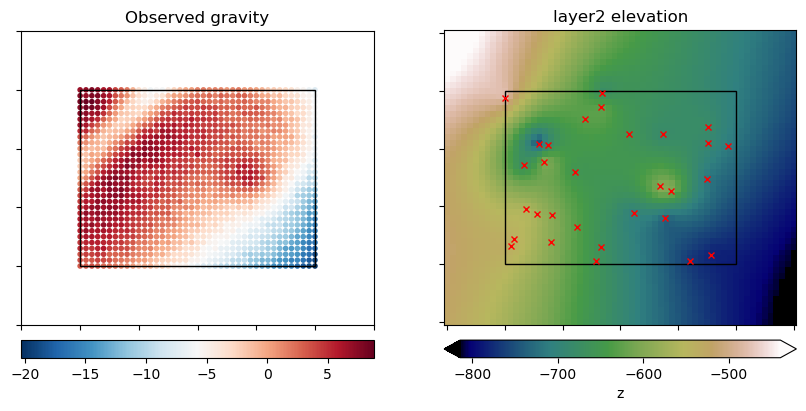

In [5]:
plots.plot_inputs(
    returned,
    grav_spacing=grav_spacing,
    active_layer=active_layer,
    region=buffer_region,
    inversion_region=inversion_region,
    # plot_type='pygmt', # 54 secs
    plot_type="xarray",  # 2.1 secs
    # kwargs
    plotting_constraints=constraint_points,
)

# Invert to recover full-res starting model

## make prism layers

In [10]:
inv.grids_to_prism_layers(
    inv_layers,
    # thickness_threshold=100,
    registration=registration,
    # lowest_bottom=-5e3,
)

plots.plot_prism_layers(
    inv_layers,
    cmap="viridis",
    plot_type="3D",
    # layers_for_3d=[active_layer],
    color_by="density",
    # color_by="thickness",
    zscale=200,
    clip_box=False,
    log_scale=False,
)

********** layer2 top: -651m and bottom: -827m **********


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [7]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(
            z=inv_layers[active_layer]["grid"].values,
            colorscale="Greens",
            opacity=0.9,
            colorbar_x=0.95,
        ),
    ],
)

camera = dict(eye=dict(x=1, y=1, z=1))

fig.update_layout(
    title="1 Layer Model",
    scene_aspectmode="manual",
    scene_aspectratio=dict(x=1, y=1, z=1),
)

fig.show()

## forward gravity

  0%|          | 0/1271 [00:00<?, ?it/s]

3111 prisms in layer2 layer
finished layer2 layer


,x,y,Gobs,z,layer2_forward_grav,forward_total
count,1271.00000,1271.000000,1271.000000,1271.0,1.271000e+03,1.271000e+03
mean,40000.00000,30000.000000,0.000000,1000.0,-4.919572e-16,-4.919572e-16
std,23673.63396,17895.585168,5.776525,0.0,2.700933e+00,2.700933e+00
min,0.00000,0.000000,-20.270966,1000.0,-6.374589e+00,-6.374589e+00
25%,20000.00000,14000.000000,-3.260843,1000.0,-1.638399e+00,-1.638399e+00
50%,40000.00000,30000.000000,1.563296,1000.0,1.847064e-01,1.847064e-01
75%,60000.00000,46000.000000,4.383427,1000.0,1.484651e+00,1.484651e+00
max,80000.00000,60000.000000,8.790890,1000.0,8.244810e+00,8.244810e+00


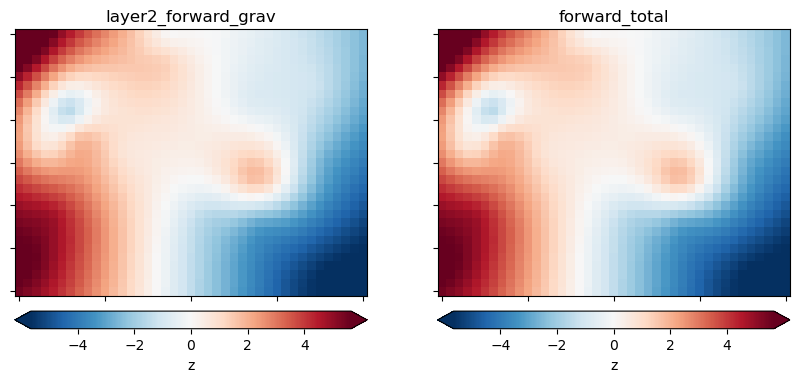

In [11]:
df_forward = inv.forward_grav_layers(
    inv_layers,
    grav,
    progressbar=True,
    parallel=True,
)

forward_grids = plots.forward_grav_plotting(
    df_forward,
    region=inversion_region,
    grav_spacing=grav_spacing,
    # kwargs
    # plot_dists = True,
)

df_forward.describe()

## anomalies

The `observed gravity` is the combination of the signal from the `bathymetry` (sediment-water contact) and the `crust` (sediment-basement contact). While both of these fields have a long-wavelength components, almost all of the short-wavelength signal is resulting from the bathymetry. We need to ensure when we invert for the bathymetry, we aren't including a residual signal coming from unknown crustal structures. 

To do this, we need to accurately seperate the `regional` field from the forward-observed gravity misfit. This `regional` field should theoretically contain every gravity signal other than the that resulting from the bathymetry surface. 

Here, since we precisely know the regional component (the forward gravity of Layer 3), we can tune our regional-residual seperation method. 

### load the true regional and layer2 gravity anomalies

In [34]:
# true_regional = fetch.resample_grid(
#     synthetic_gravity.layer3_forward_grav,
#     region=inversion_region,
#     spacing=grav_spacing,
#     registration=registration,
# )

# true_layer2_grav = fetch.resample_grid(
#     synthetic_gravity.layer2_forward_grav,
#     region=inversion_region,
#     spacing=grav_spacing,
#     registration=registration,
# )

In [35]:
# bins = true_regional.plot.hist(bins=50)
# bins = forward_grids['forward_total'].plot.hist(bins=50, alpha=.5)

In [36]:
# bins = true_layer2_grav.plot.hist(bins=50)
# bins = forward_grids['layer2_forward_grav'].plot.hist(bins=50, alpha=.5)

In [37]:
# true_regional_norm = inv_utils.normalize_xarray(true_regional,
#     np.nanmin(forward_grids['forward_total'].values),
#     np.nanmax(forward_grids['forward_total'].values),
#     )
# # forward_total_norm = inv_utils.normalize_xarray(forward_grids['forward_total'],
# #     np.nanmin(forward_grids['forward_total'].values),
# #     np.nanmax(forward_grids['forward_total'].values),
# #     )

# bins = true_regional_norm.plot.hist(bins=50)
# bins = forward_grids['forward_total'].plot.hist(bins=50, alpha=.5)

In [38]:
# true_layer2_grav_norm = inv_utils.normalize_xarray(true_layer2_grav,
#     np.nanmin(forward_grids['layer2_forward_grav'].values),
#     np.nanmax(forward_grids['layer2_forward_grav'].values),
#     )

# bins = true_layer2_grav_norm.plot.hist(bins=50)
# bins = forward_grids['layer2_forward_grav'].plot.hist(bins=50, alpha=.5)

In [39]:
# grids = utils.grd_compare(
#     true_regional_norm,
#     forward_grids['forward_total'],
#     region=inversion_region,
#     plot=True,
#     plot_type="xarray",
#     grid1_name='True regional gravity',
#     grid2_name='Total forward gravity',
# )

In [40]:
# grids = utils.grd_compare(
#     true_layer2_grav_norm,
#     forward_grids['layer2_forward_grav'],
#     region=inversion_region,
#     plot=True,
#     plot_type="xarray",
#     grid1_name='True Layer2 gravity',
#     grid2_name='Calculated layer2 gravity',
# )

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) Filter method: Apply a low-pass filter to the misfit
2) Trend method: Fit a trend to the misfit
3) Constraints method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) Equivalent-Sources method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, this are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in a regional msifit closest to the true layer 3 forward gravity. 


Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [19]:
# kwargs = dict(
#     method='regional comparison', # compare layer3 forward grav and calculated regional
#     # method='minimize constraints', # minimize calculated residuals at constraints
#     # method='residual comparison', # compare low-res layer2 forward grav and calcualted regional
#     true_regional=true_regional_norm,
#     true_residual=true_residual_norm,
#     layers=inv_layers,
#     input_grav=df_forward,
#     grav_spacing=grav_spacing,
#     inversion_region=inversion_region,
#     constraints=constraint_points,
# )

#### Optimize 4 methods together

In [20]:
# study, method = inv_utils.optimize_regional_together(20, **kwargs)

In [21]:
# inv_utils.plot_best_param(study, method, **kwargs)

#### Optimize methods individually

In [22]:
# studies = inv_utils.optimize_regional_loop(5, **kwargs)

In [23]:
# inv_utils.plot_best_params_per_method(studies, **kwargs)

In [9]:
# get best regional method and parameter from combined optimization
# regional_method = method
# param = study.params_param.iloc[0]

# choice regional method and get best params
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"
# param = studies[regional_method].params_param.iloc[0]
param = 0
# get params from optimization, or use custom inputs
filter = param
trend = param
tension = param / 10
eq_sources = param

# filter = "g31e3"
# trend = 10
tension = 0.25
# eq_sources = 2000e3


if regional_method == "filter":
    title = f"Method: {regional_method} (g{int(filter/1e3)}km)"
    filter = f"g{param}"

elif regional_method == "trend":
    title = f"Method: {regional_method} (order={trend})"

elif regional_method == "constraints":
    title = f"Method: {regional_method} (tension factor={tension})"

elif regional_method == "eq_sources":
    title = f"Method: {regional_method} (Source depth={int(eq_sources/1e3)}km)"

,x,y,Gobs,z,layer2_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,1271.00000,1271.000000,1271.000000,1271.0,1.271000e+03,1.271000e+03,1271.000000,1.271000e+03,1271.000000,1271.000000
mean,40000.00000,30000.000000,0.000000,1000.0,-4.919572e-16,-4.919572e-16,0.000000,3.577871e-16,0.337621,-0.337621
std,23673.63396,17895.585168,5.776525,0.0,2.700933e+00,2.700933e+00,5.776525,3.792152e+00,3.030935,1.746248
min,0.00000,0.000000,-20.270966,1000.0,-6.374589e+00,-6.374589e+00,-20.270966,-1.389638e+01,-9.372272,-8.863244
25%,20000.00000,14000.000000,-3.260843,1000.0,-1.638399e+00,-1.638399e+00,-3.260843,-2.209583e+00,-1.306778,-0.747735
50%,40000.00000,30000.000000,1.563296,1000.0,1.847064e-01,1.847064e-01,1.563296,6.854700e-01,1.305481,0.029317
75%,60000.00000,46000.000000,4.383427,1000.0,1.484651e+00,1.484651e+00,4.383427,3.025802e+00,2.575925,0.614699
max,80000.00000,60000.000000,8.790890,1000.0,8.244810e+00,8.244810e+00,8.790890,6.584515e+00,4.569829,3.919210


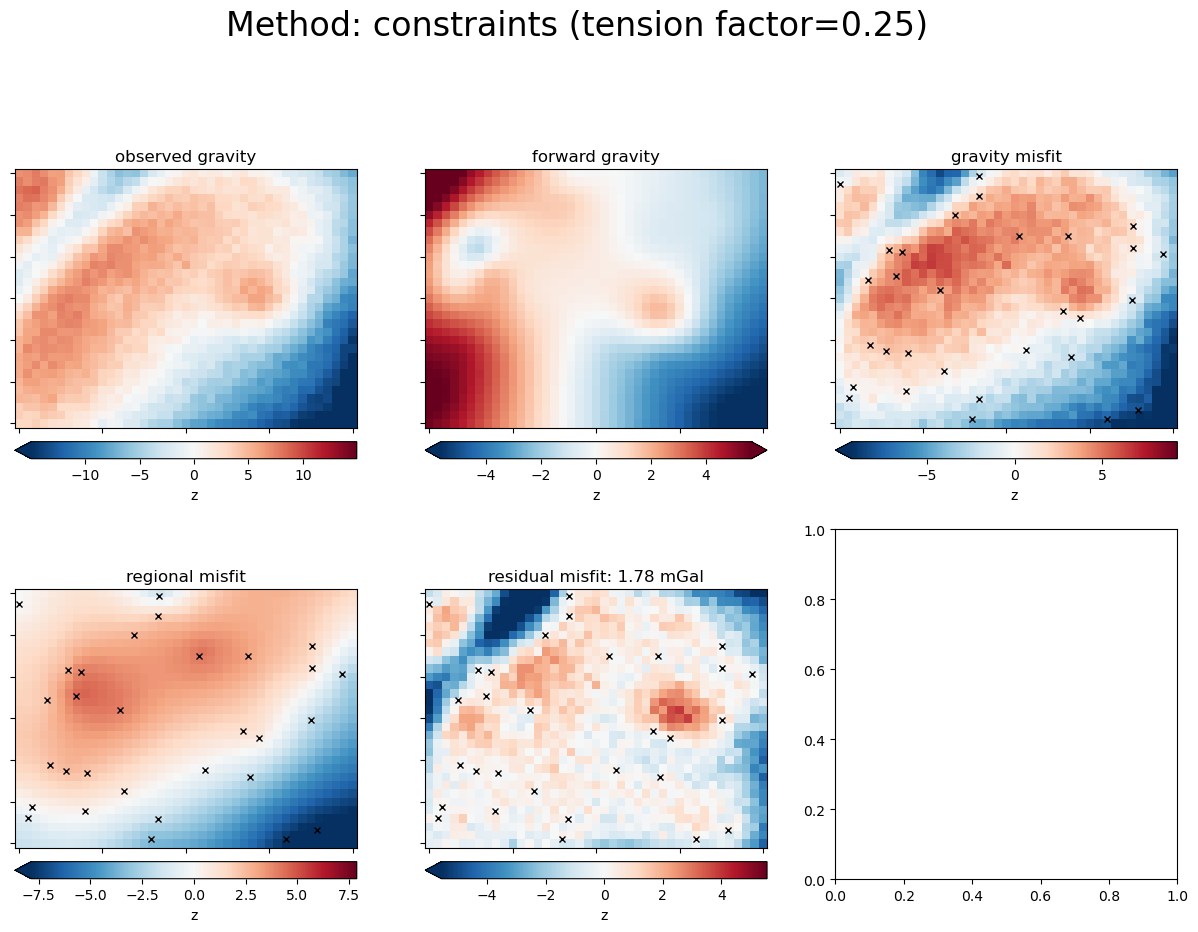

In [10]:
df_anomalies = inv.anomalies(
    layers=inv_layers,
    input_grav=df_forward,
    grav_spacing=grav_spacing,
    registration=registration,
    regional_method=regional_method,
    crs="3031",
    # KWARGS
    inversion_region=inversion_region,
    # filter kwargs
    filter=filter,
    # trend kwargs
    trend=trend,
    fill_method="pygmt",
    # fill_method='rioxarray',
    # constraint kwargs
    constraints=constraint_points,
    tension_factor=tension,
    # eq sources kwargs
    eq_sources=eq_sources,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
)

anom_grids = plots.anomalies_plotting(
    df_anomalies,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=title,
    constraints=constraint_points,
    # plot_dists=True,
    # plot_power_spectrums=True,
)

df_anomalies.describe()

## inversion

In [34]:
# %%snakeviz --new-tab

topo_results, grav_results, layers_update = inv.geo_inversion_dens_contrast(
    active_layer=active_layer,
    layers_dict=inv_layers,
    input_grav=df_forward,
    # input_grav=df_anomalies,
    buffer_region=buffer_region,
    regional_method=regional_method,
    grav_spacing=grav_spacing,
    l2_norm_tolerance=0.1,
    delta_l2_norm_tolerance=0.06,
    max_iterations=10,
    # registration="g",
    # deriv_type="annulus",
    deriv_type="prisms",
    delta=1,
    # solver_type="scipy conjugate",
    # solver_type="numpy least squares",
    solver_type="scipy least squares",
    # solver_type="verde least squares",  # issue with top row, values to extreme
    # solver_type="steepest descent",
    # solver_type="gauss newton",
    solver_damping=0.1,
    # apply_weights=True,
    # max_layer_change_per_iter=5e3,
    # save_results = True,
    # kwargs
    above_layer="../synthetic_data/synthetic_layer1_simple.zarr",
    apply_constraints=False,
    # filter kwargs
    filter=filter,
    # trend kwargs
    trend=trend,
    fill_method="pygmt",
    # fill_method='rioxarray',
    # constraint kwargs
    constraints=constraint_points,
    tension_factor=tension,
    # eq sources kwargs
    eq_sources=eq_sources,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
    # fname_topo = "topo_results_5k_constraints_base",
    # fname_gravity = "gravity_results_5k_constraints_base",
)


##############################################################################################
iteration 1
initial misfit RMSE = 1.78 mGal
initial L2-norm : 1.33
initial delta L2-norm : inf
spacing larger than original, filtering and resampling
Layer correction mean: 0 m, RMSE:3 m
constraints not applied
updating the misfits

updated misfit RMSE: 1.63
updated L2-norm: 1.28,  tolerance: 0.1
updated delta L2-norm : 1.04,  tolerance: 0.06

##############################################################################################
iteration 2
initial misfit RMSE = 1.63 mGal
initial L2-norm : 1.28
initial delta L2-norm : 1.04
spacing larger than original, filtering and resampling
Layer correction mean: 0 m, RMSE:3 m
constraints not applied
updating the misfits

updated misfit RMSE: 1.5
updated L2-norm: 1.22,  tolerance: 0.1
updated delta L2-norm : 1.04,  tolerance: 0.06

##############################################################################################
iteration 3
initial mi

returning original grid
returning original grid


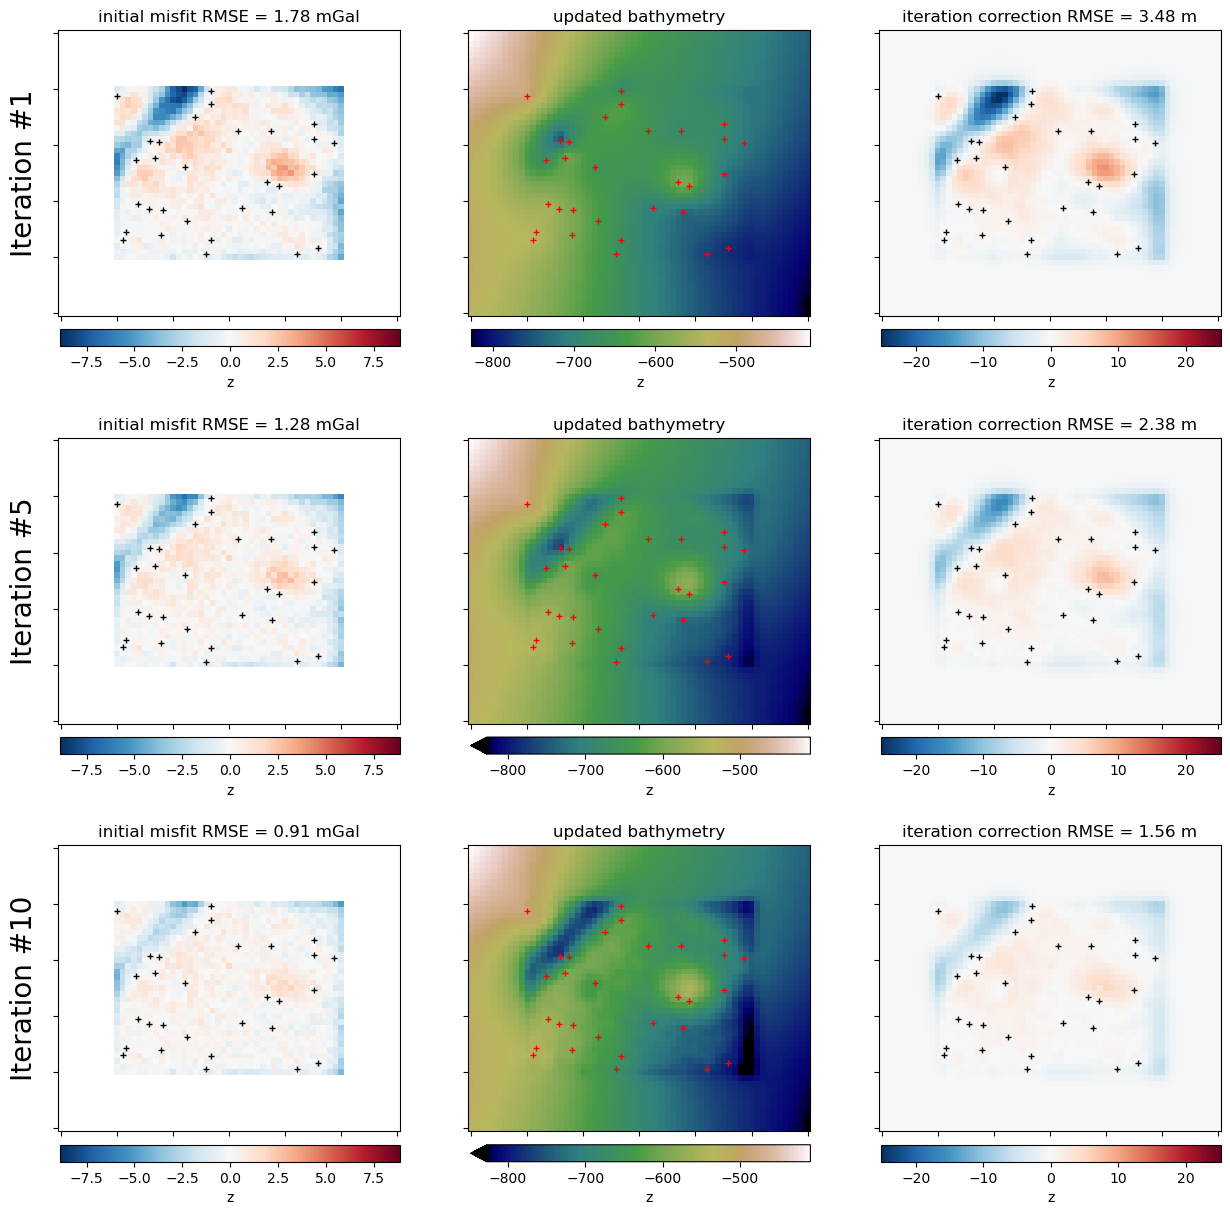

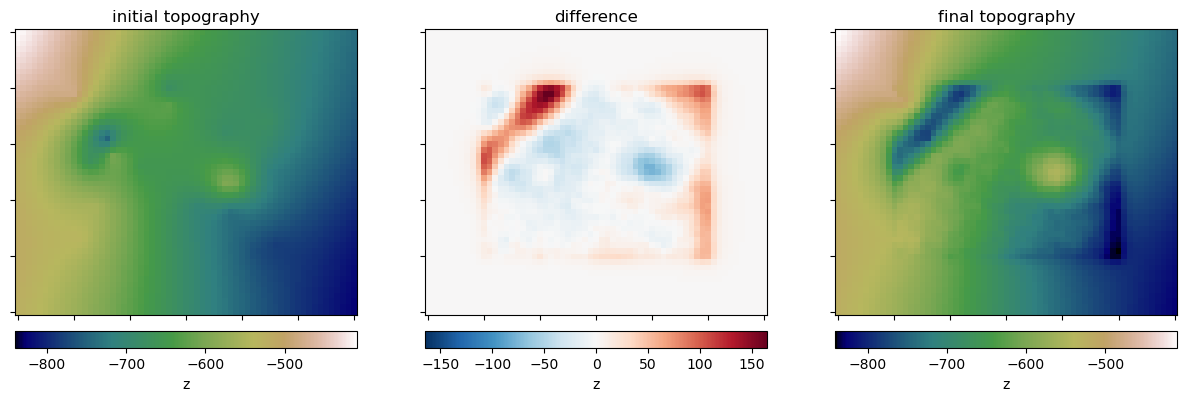

In [36]:
grids = plots.plot_inversion_results(
    grav_results=grav_results,
    topo_results=topo_results,
    layers_dict=inv_layers,
    active_layer=active_layer,
    grav_spacing=grav_spacing,
    region=buffer_region,
    # registration="g",
    iters_to_plot=3,
    # plot_iters = False,
    # plot_topo_results=False,
    plot_grav_results=False,
    # kwargs
    constraints=constraint_points,
)

## compare inverted bathymetry to synthetic starting bathymetry

grid spacings don't match, using smaller spacing (1000.0m).
returning original grid
Warning, requested spacing (1000.0) is smaller than the original  (2000.0).


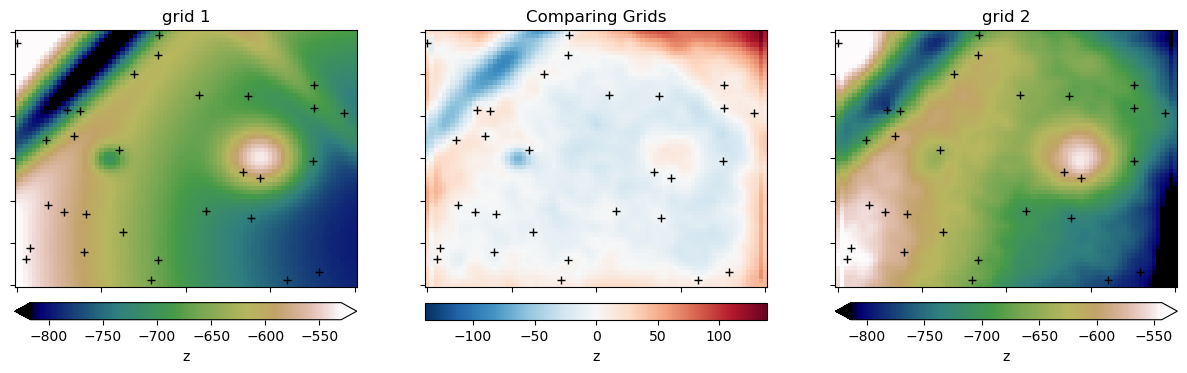

In [38]:
grids = utils.grd_compare(
    true_layer2,
    layers_update[active_layer]["prisms"].top,
    region=inversion_region,
    plot=True,
    plot_type="xarray",
    cmap="gist_earth",
    robust=True,
    points=constraint_points,
)

grid spacings don't match, using smaller spacing (1000.0m).
returning original grid
Warning, requested spacing (1000.0) is smaller than the original  (2000.0).


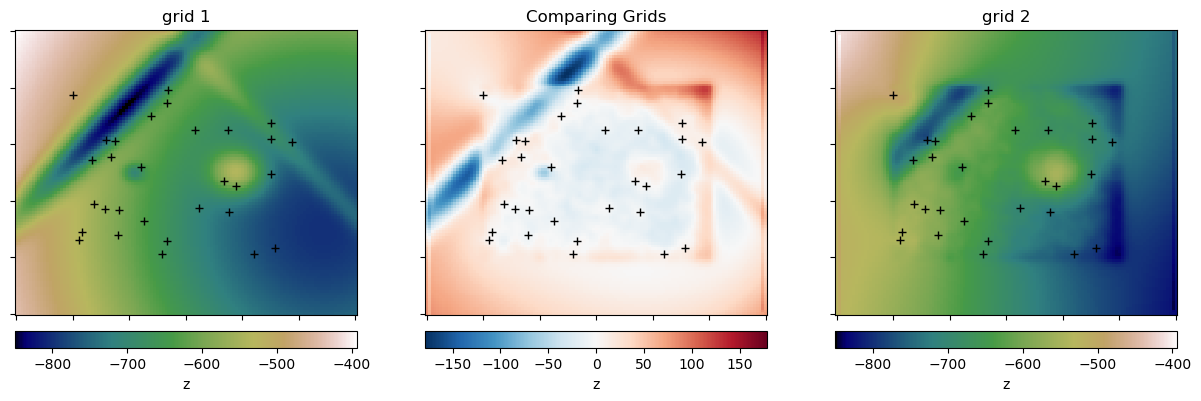

In [40]:
grids = utils.grd_compare(
    true_layer2,
    layers_update[active_layer]["prisms"].top,
    region=buffer_region,
    plot=True,
    plot_type="xarray",
    cmap="gist_earth",
    # robust=True,
    points=constraint_points,
)

In [33]:
# def ackley(x, y):
#     return (
#         -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
#         - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
#         + np.exp(1)
#         + 20
#     )


# # Create gridded data
# INC = 0.05
# x = np.arange(-5, 5 + INC, INC)
# y = np.arange(-5, 5 + INC, INC)
# data = xr.DataArray(ackley(*np.meshgrid(x, y)), coords=(x, y))
# data